Load the photo to be processed and display it

d:\Anaconda\envs\py38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Anaconda\envs\py38\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
d:\Anaconda\envs\py38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


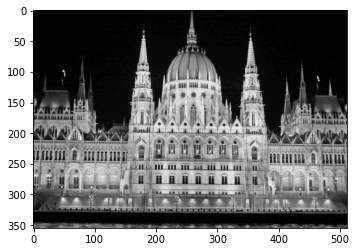

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

img = cv2.imread('./img/image1.png')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.imshow(img_gray,cmap='gray')
img_use=img_gray

Gaussian blur the image for later Retinex Processing

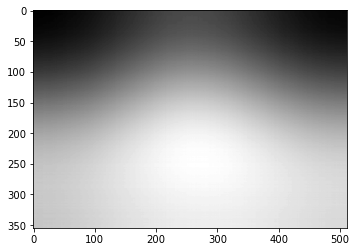

In [2]:
imgz=img_gray
ones = np.ones((imgz.shape[0],imgz.shape[1]))
img_gauss = cv2.GaussianBlur(imgz,(511,511),90)
imgz=img_gauss
plt.imshow(img_gauss,cmap = 'gray')

Adjust the contrast of the image

[[0.21052633 0.21052633 0.21052633 ... 0.20000001 0.20000001 0.20000001]
 [0.21052633 0.21052633 0.21052633 ... 0.20000001 0.20000001 0.20000001]
 [0.21052633 0.21052633 0.21052633 ... 0.20000001 0.20000001 0.20000001]
 ...
 [1.23469389 0.98979593 1.01020409 ... 0.78301888 0.7904762  0.58095239]
 [0.47959185 0.74489797 1.35714287 ... 0.78301888 0.78301888 0.55660378]
 [0.91836736 0.85714287 0.9489796  ... 0.70754718 0.54716982 0.79245284]]


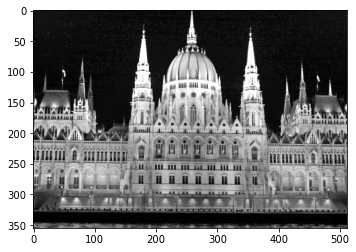

In [3]:
#R=np.log(img_gray+0.0000001)-np.log(img_gauss+0.0000001)
#R =normalize(R)
R=img_use/img_gauss+0.00000001
print(R)
#对比度调整 #Adjust the contrast
alpha = 100# 调整参数 #Adjust the parameter
beta = 10
adjusted = np.clip(alpha * R + beta, 0, 255).astype(np.uint8)
plt.imshow(adjusted,cmap = 'gray')

Apply a Min-filter to the image and a Joint Bilateral Filter to the image according to the paper

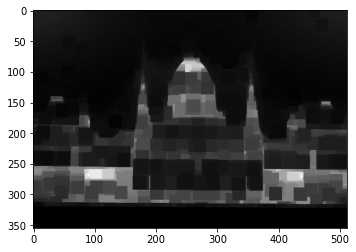

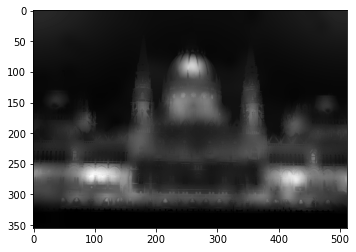

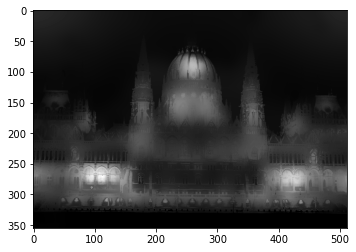

In [4]:
#min-filter
img_min = cv2.erode(adjusted,np.ones((21,21)))#使用调整对比度后的R #use R after contrast adjustment
img_min = img_min.astype(np.float32)
img_gray = img_gray.astype(np.float32)
plt.imshow(img_min,cmap = 'gray')
#joint-bilateral filter
#img_joint1 = img_min.copy()
for i in range(3):   
    #domain transform filter
    #img_joint1 = cv2.ximgproc.dtFilter(img_gray,img_min,30,10,2,cv2.ximgproc.DTF_NC)
    img_joint2 = cv2.ximgproc.jointBilateralFilter(img_gray,img_min,61,15,10)
    img_joint1 = cv2.ximgproc.jointBilateralFilter(img_gray,img_min,-1,30,10)
plt.figure()
plt.imshow(img_joint1,cmap = 'gray')
plt.figure()
plt.imshow(img_joint2,cmap = 'gray')

Test the earlier processing steps on the image by whether the image can be restored by L and R

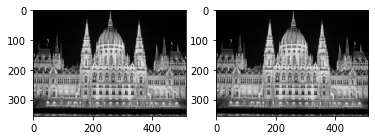

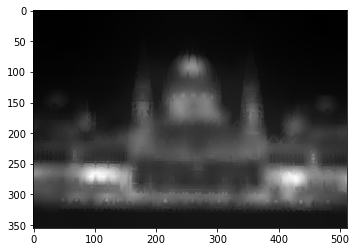

In [5]:
#复原 #restore
F = R*img_gauss.astype(np.float32)#注：这里用的是调整对比度前的R #here use the R before adjusting contrast, adjust contrast is just for display
F = F.astype(np.uint8)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(F,cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(img_use,cmap = 'gray')
F2 = img_joint1*img_gauss
plt.figure()
plt.imshow(F2,cmap = 'gray')

Def the min-max normalization function

In [6]:
def normalize(img):
    img = img.astype(np.float32)
    img = (img - np.min(img))/(np.max(img)-np.min(img))
    return img

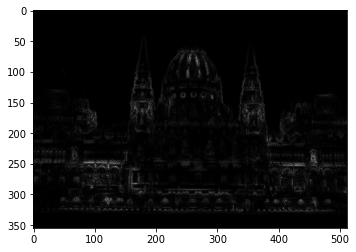

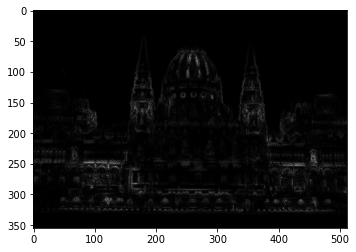

In [7]:
img_S = normalize(img_joint1)
img_v = cv2.GaussianBlur(img_S,(5,5),2)
img_v =cv2.absdiff(img_S,img_v)
plt.figure()
plt.imshow(img_v,cmap = 'gray')
#calhist,感觉以下部分没用
H_k = 0
X_k = 0
hist = cv2.calcHist([img_v],[0],None,[500],[0,1])#直方图
sampling_ratio = 1/400
inv_m = 1/500
offset = inv_m/2
n = img_v.shape[0]*img_v.shape[1]
nt = int(n*(1-sampling_ratio))
epsilon = 0.0000001
sx_max = 1 + epsilon
sx_min = 1 - epsilon
for i in range(500):
    h_i = hist[i]
    H_k += h_i
    x = i*inv_m + offset
    X_k += x*h_i
    s = (H_k-nt)/X_k
    sx =s * x
    if sx > sx_min:
        break
result = np.minimum(img_v*s,1)
plt.figure()
plt.imshow(result,cmap = 'gray')




Use Floyd-Steinberg dithering to get the lighting points

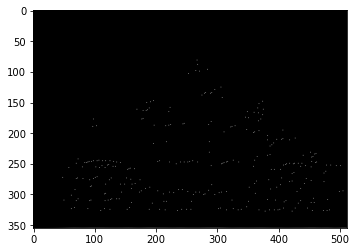

In [8]:
#ditheringFloydSteinbergPoints
def ditheringFloydSteinbergPoints(img):
    img = img.astype(np.float32)
    #img = img/255
    img = img.astype(np.float32)
    img = np.pad(img,((0,0),(0,1)),'constant',constant_values = 0)
    for i in range(img.shape[0]-1):
        for j in range(1,img.shape[1]-1):
            old_pixel = img[i,j]
            new_pixel = np.round(old_pixel)
            img[i,j] = new_pixel
            error = old_pixel - new_pixel
            img[i,j+1] += error * 7/16
            img[i+1,j-1] += error * 3/16
            img[i+1,j] += error * 5/16
            img[i+1,j+1] += error * 1/16
    return img[:,:-1]
img_dithering = ditheringFloydSteinbergPoints(result)#用img_v效果一样

plt.figure()
plt.imshow(img_dithering,cmap = 'gray')

Draw square on the dithered points to get the possible lighting points just like the paper

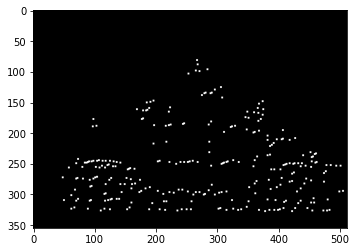

In [9]:
img_dithering_dis = np.zeros(img_dithering.shape)
for i in range(img_dithering.shape[0]):
    for j in range(img_dithering.shape[1]):
        if img_dithering[i,j] > 0.5:
            #在[i.j]上画正方形 #draw a square on [i.j]
            img_dithering_dis = cv2.rectangle(img_dithering_dis,(j-1,i-1),(j+1,i+1),(255),-1)
plt.figure()
plt.imshow(img_dithering_dis,cmap = 'gray')

Choose the lighting points according to the pipeline in the paper

In [10]:
def dist(Point0,PointA):#计算距离
    distance=pow((Point0[0]-PointA[0]),2) + pow((Point0[1]-PointA[1]),2)
    distance=pow(distance,0.5)
    return distance

def num1(img):#计算亮点数量
    img=img/img.max()
    hi=img.shape[0]
    wi=img.shape[1]
    countp=0
    for i in range(hi):
        for j in range(wi):
            if(img[i,j]==1):
                countp+=1
    return countp

def point_rebuild(img):#把有亮点的图转化为矩阵，如果有100个亮点，就是100*2的矩阵
    img=img/img.max()     
    hi=img.shape[0]
    wi=img.shape[1]
    print(hi,wi)
    point_set=np.zeros((num1(img),2))
    countp1=0
    for i in range(hi):
        for j in range(wi):
            if(img[i,j]==1):
                point_set[countp1,0]=i   
                point_set[countp1,1]=j 
                countp1+=1
    return point_set

def rng(point):
    pp=random.sample(point, 1)[0]
    return pp


355 512
(195.0, 217.0)
(98.0, 275.0)
(348.0, 319.0)
(348.0, 193.0)
(242.0, 324.0)


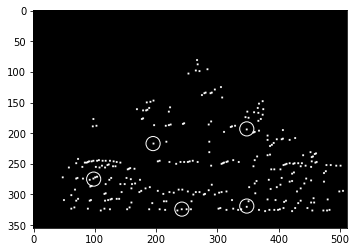

In [11]:
Nl=5
gama=2
point_A=set()
point_D=set()
point_S=set()
point_T=set()
point_Dp=set()
sigs=10
D1=img_dithering_dis.copy()
D2=point_rebuild(D1) #D2存储了抖动得到的亮点
for i in range(num1(D1)):
    p_use=(D2[i,:][1],D2[i,:][0])
    point_D.add(p_use)
rl=(pow(D1.shape[0]*D1.shape[1]/Nl,0.5))/2
count=0
while (len(point_A)<Nl):
    count=count+1
    p0=rng(point_D)
    #生成集合A
    point_A.add(p0)
    #生成集合Dp
    for pi in point_D:
        if(dist(pi,p0)>=rl):
            point_Dp.add(pi)

    for t in range(1,Nl):
        #求S
        point_S.clear()
        for pi in point_Dp:
            for pj in point_A:
                if(dist(pi,pj)<=rl*gama):
                    point_S.add(pi)
        if (bool(point_S)):
            Tm=0
            
            for ps in point_S:
                #求T
                for pd in point_Dp:
                    if(dist(ps,pd)>=rl):
                        point_T.add(pd)
                if (len(point_T)>Tm):
                    Tm=len(point_T)
                    pnext=ps
            point_A.add(pnext)
        else:
            if (bool(point_Dp)):
                pnext=rng(point_Dp)
                point_A.add(pnext)
            else:
                break
        point_Dpc=point_Dp.copy()
        for pd in point_Dpc:
            if (dist(pd,pnext)<rl):
                point_Dp.remove(pd)

    if (len(point_A)!=Nl):
        rl=rl-sigs
        point_A.clear()

plt.imshow(D1,cmap = 'gray')
for ps in point_A:
    print(ps)
    plt.scatter(ps[0], ps[1],facecolor='none', edgecolor='w', s=200)
plt.show()

In [12]:
#将函数映射到0-1 #map a function to 0-1 using sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

When finally generating the Relight light source, we found a problem in the original paper, that is, the boundary when generating the light source is too obvious, especially in the background part where the light source should not appear at all, and it is difficult to have such an obvious boundary effect without a searchlight source in reality, so we JBF processed it after generating the relight mask to make the boundary more natural. The final result is also much better than the original paper.

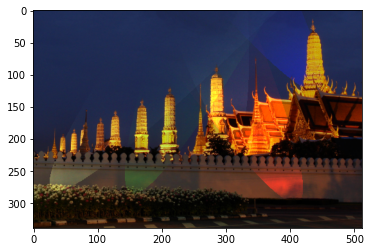 </br>
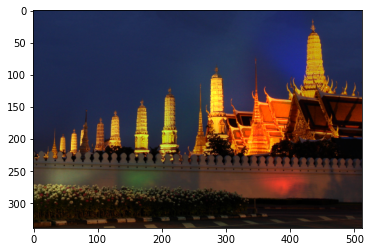

A small test to see if the searchlight effect is generated correctly

In [ ]:
#测试直线方程
a = 1
b = -1

t = 1
y = 158
x = 258
distance = 20#线与点的距离
root = np.sqrt(a**2+b**2)
c1 = (-distance*np.sqrt(root)-a*y-b*x)
c2 =  (distance*np.sqrt(root)-a*y-b*x)
empty3=empty.copy()
for i in range(0,empty3.shape[0]):#y
        for j in range(0,empty3.shape[1]):#x
            if a*i+b*j+c2>=0:
                empty3[i,j]=100
            #if np.sqrt((i-y)**2+(j-x)**2)<=t*np.abs(a*i+b*j+c1)/root:
            #    empty3[empty.shape[0]-1-i,j]=200
            if np.sqrt((i-y)**2+(j-x)**2)<=t*np.abs(a*i+b*j+c2)/root:
                empty3[i,j]=200
            if y==i and x==j:
                 #画圆
                cv2.circle(empty3, (j,empty.shape[0]-1-i), 3, 255, -1)
print(a*y+b*x+c1,a*y+b*x+c2)
plt.imshow(empty3,cmap = 'gray')

A small difference from the paper, we chose not to use the LAB color space, and found RGB light space can be used directly, and the effect is the same.

246.2
195.0 217.0
left
1 -0.23147521650098232 -181.99367439732976
98.0 275.0
left
1 -0.5782576626712422 -229.0785604745484
348.0 319.0
right
1 0.39906199389116864 -468.2499169049857
348.0 193.0
right
1 0.39906199389116864 -342.2499169049857
242.0 324.0
left
1 -0.12626712405200197 -303.48297833365336
(5, 355, 512)


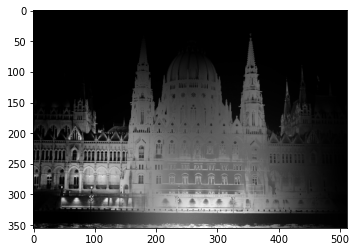

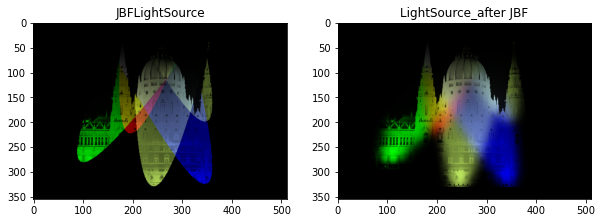

In [20]:
img_F2=F2.copy()
img=img.copy()
mask_l = []
light_color=np.zeros((5,3))
light_color[0,:]=[255,0,0]
light_color[1,:]=[0,255,0]
light_color[2,:]=[0,0,255]
light_color[3,:]=[180,220,90]
light_color[4,:]=[180,220,90]
mode = 'JBF'
distance = 10  
point=list(point_A)
point = np.array(point)
center_point_x = np.sum(point[:,0])/len(point)
print(center_point_x)
LightSource = np.zeros(img_F2.shape, dtype=np.float32)#LightSource
for point1 in point:
    LightSource = cv2.circle(LightSource, (int(point1[0]),int(point1[1])), 10, 255, -1)
if(mode == 'GF'):
    LightSource = cv2.GaussianBlur(LightSource, (0, 0), 40)
if(mode == 'JBF'):
    gray_f = img_gray.astype(np.float32) 
    LightSource = LightSource.astype(np.float32) 
    for t in range(1,3):
        LightSource = cv2.ximgproc.jointBilateralFilter(gray_f,LightSource,-1,30,60)
        #LightSource = cv2.ximgproc.dtFilter(gray_f,LightSource,20,10,1)#限制打光边界
        
        #LightSource = cv2.ximgproc.jointBilateralFilter(img_joint1,LightSource,61,30,10)
#domain transform
LightSource = LightSource/LightSource.max()
plt.figure()
plt.imshow(LightSource,cmap = 'gray')
for point1 in point:
    im_size=img_F2.shape
    point_source_pos = point1
    point_source_intensity = 1
    sigma = 100
    image = np.zeros(im_size, dtype=np.float32)
    size=img.shape
    empty=np.zeros(im_size, dtype=np.float32)
    image = LightSource
    empty2=empty.copy()
    x=point1[0]
    y=point1[1]
    print(x,y)
    #计算直线方程
    if x <= center_point_x:
        print('left')
        a = 1
        b = -sigmoid(np.sqrt((x-center_point_x)**2)/empty.shape[1]*8-2)#当x与中心点的距离越大，b越大
        root = np.sqrt(a**2+b**2)
        c =  (-distance*np.sqrt(root)-a*y-b*x)#x,y始终与直线相距distance
    else:
        print('right')
        a = 1
        b = sigmoid(np.sqrt((x-center_point_x)**2)/empty.shape[1]*8-2)#当x与中心点的距离越大，b越大
        root = np.sqrt(a**2+b**2)
        c =  (-distance*np.sqrt(root)-a*y-b*x)#x,y始终与直线相距distance
    print(a,b,c)
    for i in range(0,empty.shape[0]):#y
        for j in range(0,empty.shape[1]):#x
            if np.sqrt((i-y)**2+(j-x)**2)<=np.abs(a*i+b*j+c)/root:
                empty2[i,j]=1
    mask_l.append(empty2*image)
print(np.array(mask_l).shape)
mask_l = np.array(mask_l)
mask = np.zeros(img_F2.shape, dtype=np.float32)
mask2 = np.zeros((img_F2.shape[0],img_F2.shape[1],3), dtype=np.float32)
mask3=mask2.copy()
for m in mask_l:
    mask += m
for k in range(3):
    mrank=0
    for m in mask_l:
        mask2[:,:,k-1] += m*light_color[mrank,k-1]
        mrank += 1
    mask3[:,:,k-1]=cv2.ximgproc.jointBilateralFilter(gray_f,mask2[:,:,k-1],61,30,10)
mask = mask/mask.max().astype(np.float32)
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.title(mode+'LightSource')
mask2 = mask2/mask2.max()*255
plt.imshow(mask2.astype(np.uint8))
plt.subplot(1,2,2)
plt.title('LightSource_after JBF')
#显示RGB mask
mask3 = mask3/mask3.max()*255
plt.imshow(mask3.astype(np.uint8))


o is the proportion of the intensity of the original picture, o the larger the building, the brighter the original building.
k is the proportion of intensity of the relight light source, the larger the k, the greater the brightness of the relight light
Mixing scheme: For each pixel, the intensity ratio of the original picture is o, and the intensity ratio of the relight light source is k, then the final intensity is o* original intensity + k*relight intensity, according to the previous lighting color selection, weighted on the three channels through the Fz parameter to reflect the color of the light source.</br>
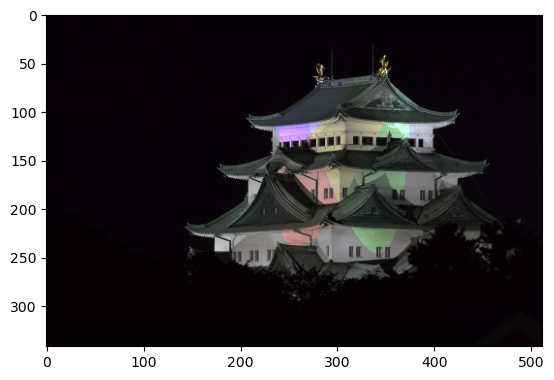
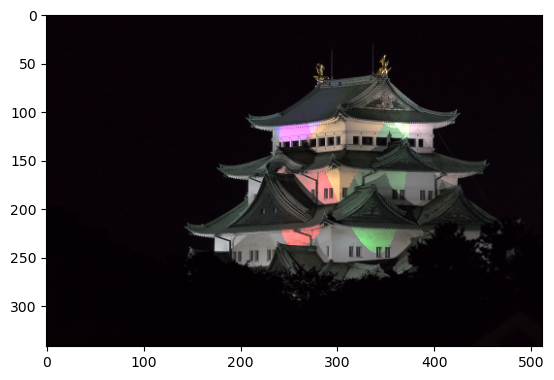

Sample without our JBF processing

380.3


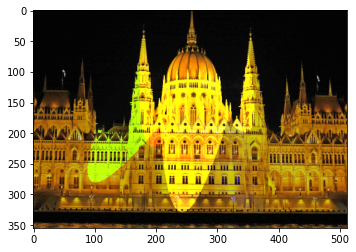

In [14]:
#display
o=0.8
k=1.5
#plt.imshow(np.array(mask_l)[0],cmap = 'gray')
plt.figure()
Fz0=normalize(mask2[:,:,0])
Fz1=normalize(mask2[:,:,1])
Fz2=normalize(mask2[:,:,2])

#Fz0=normalize(mask2[:,:,0]*img_joint1)
#Fz1=normalize(mask2[:,:,1]*img_joint1)
#Fz2=normalize(mask2[:,:,2]*img_joint1)
#plt.imshow(F,cmap = 'gray')
#plt.figure()
output=np.zeros(img.shape)
#output=(o+k*F)*img
print(np.max(o+k*F))

output[:,:,0]=np.clip(img[:,:,0]*(o+k*Fz0),0,255)
output[:,:,1]=np.clip(img[:,:,1]*(o+k*Fz1),0,255)
output[:,:,2]=np.clip(img[:,:,2]*(o+k*Fz2),0,255)
plt.imshow(output.astype(np.uint8))


    

Sample with our JBF processing

254.8


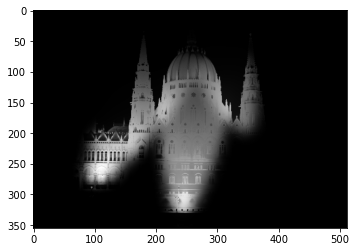

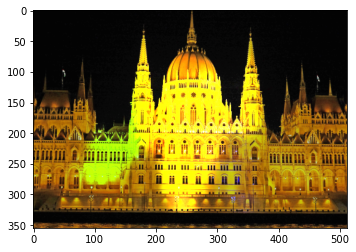

In [23]:
#plt.imshow(np.array(mask_l)[0],cmap = 'gray')
#plt.figure()
Fz0=normalize(mask3[:,:,0])
Fz1=normalize(mask3[:,:,1])
Fz2=normalize(mask3[:,:,2])
plt.imshow(,cmap = 'gray')
plt.figure()
output=np.zeros(img.shape)
print(np.max(o+k*F))

output[:,:,0]=np.clip(img[:,:,0]*(o+k*Fz0),0,255)
output[:,:,1]=np.clip(img[:,:,1]*(o+k*Fz1),0,255)
output[:,:,2]=np.clip(img[:,:,2]*(o+k*Fz2),0,255)
plt.imshow(output.astype(np.uint8))